# Computer Vision, Fall 2022

#### Name: Adam El Kholy

#### <font color='red'>Exercise 5, return latest on Sunday 16.10.2022 at 23.59 via Moodle</font>

Return the answer in PDF and Jupyter Notebook formats.

## Ex 5.1. Camera matrix (4 p)

Using the focal length, principal point and skew coefficient values given in this template, and equations given in Lecture 6, slide 49, form the camera matrix P and compute image coordinates (x,y) for an object point X (0, 0, 1, 1) when the origin of the world coordinate frame is

- exactly 3 meters away from the camera center, i.e. t = (0, 0, 3), and the camera is completely aligned with the world coordinate axis
- exactly 5 meters away from the camera center, i.e. t = (0, 0, 5), and the camera is completely aligned with the world coordinate axis
- t = (0.5, 1, 3) and the camera otherwise aligned with the world coordinate axis but it has only turned 20 degrees to the left
- t = (15, 1, 3) and the camera otherwise aligned with the world coordinate axis but it has only turned 20 degrees to the left

Discuss the phenomena behind the results.

In [6]:
import numpy as np
import cv2 as cv
np.set_printoptions(suppress=True)

# Focal length
fc = [719.302047058490760, 718.392548175289110]

# Principal point
cc = [334.631234942930060, 256.166677783686790]

# Skew coefficient
alpha_c = 0.000000000000000


# Your solution here
#P = K*[R|t]
#R = rotation matrix
#t = translation vector
#K = intrinsic: a_x is focal_x, B_x is principal_x, 
#s is skew coefficient

def get_R_matrix(angle):
    cos_t = np.cos(np.radians(angle))
    sin_t = np.sin(np.radians(angle))
    R = [[cos_t, 0, sin_t],
        [0, 1, 0],
        [-sin_t, 0, cos_t]]
    return np.array(R)

def get_Rt_matrix(angle, trans):
    R = get_R_matrix(angle)
    t = np.array([trans])
    Rt = np.concatenate((R, t.T), axis=1)
    return Rt
    
def compute_image_coords(obj_p, K, angle, trans):
    Rt = get_Rt_matrix(angle, trans)
    P = K @ Rt
    x_p = P @ obj_p
    x_p = x_p / x_p[2]   
    return P, x_p[:2]
    
K = np.array([[fc[0], alpha_c, cc[0]], 
            [0, fc[1], cc[1]],
            [0, 0, 1]])

obj_p = np.array([0, 0, 1, 1])

In [7]:
#1. t = (0, 0, 3): 
P, img_c = compute_image_coords(obj_p, K, 0, [0, 0, 3])
print("1. Exactly 3 meters away from the camera center, i.e. t = (0, 0, 3), and the camera is completely aligned with the world coordinate axis")
print(f"Camera matrix P:\n{P}\nImage coords: {img_c}\n")

#2. t = (0, 0, 5)
P, img_c = compute_image_coords(obj_p, K, 0, [0, 0, 5])
print("2. Exactly 5 meters away from the camera center, i.e. t = (0, 0, 5), and the camera is completely aligned with the world coordinate axis")
print(f"Camera matrix P:\n{P}\nImage coords: {img_c}\n")

#3. t = (0,5, 1, 3), 20 degrees left
P, img_c = compute_image_coords(obj_p, K, -20, [0.5, 1, 3])
print("3. t = (0.5, 1, 3) and the camera otherwise aligned with the world coordinate axis but it has only turned 20 degrees to the left")
print(f"Camera matrix P:\n{P}\nImage coords: {img_c}\n")

#4. t = (15, 1, 3), 20 degrees left
P, img_c = compute_image_coords(obj_p, K, -20, [15, 1, 3])
print("4. t = (15, 1, 3) and the camera otherwise aligned with the world coordinate axis but it has only turned 20 degrees to the left")
print(f"Camera matrix P:\n{P}\nImage coords: {img_c}\n")

1. Exactly 3 meters away from the camera center, i.e. t = (0, 0, 3), and the camera is completely aligned with the world coordinate axis
Camera matrix P:
[[ 719.30204706    0.          334.63123494 1003.89370483]
 [   0.          718.39254818  256.16667778  768.50003335]
 [   0.            0.            1.            3.        ]]
Image coords: [334.63123494 256.16667778]

2. Exactly 5 meters away from the camera center, i.e. t = (0, 0, 5), and the camera is completely aligned with the world coordinate axis
Camera matrix P:
[[ 719.30204706    0.          334.63123494 1673.15617471]
 [   0.          718.39254818  256.16667778 1280.83338892]
 [   0.            0.            1.            5.        ]]
Image coords: [334.63123494 256.16667778]

3. t = (0.5, 1, 3) and the camera otherwise aligned with the world coordinate axis but it has only turned 20 degrees to the left
Camera matrix P:
[[ 790.37344867    0.           68.43471293 1363.54472836]
 [  87.61416385  718.39254818  240.7179368  1

Matrices 1 and 2 have no rotation applied to them, hence the first columns of both these matrices are filled with zeroes. Note also that 1 and 2 have the same image co-ordinates due to the fact that the camera is centered exactly about the object points with the difference being a further distance for matrix 2, hence as you can imagine moving the camera further backwards does not affect image co-ordinates because it is dead centered about the image. Matrix 3 has been affected by the 20 degree rotation to the left as seen in the first column, with reasonable image co-ordinates in the bounds of the frame. Matrix 4 is much similar to 3 except for the last element in the first row being overly large. This causes out of bounds image co-ordinates, caused by the translation of 15 in the x direction.

## Ex 5.2 Fundamental matrix (4 p)

Compute the fundamental matrix F for the images image1.jpg and image2.jpg using the normalized 8-point algorithm. You may use ready made functions for detecting and matching the features, but develop the algorithm for deriving matrix F by yourself. Where are the epipoles for both images? Report both F and the two epipoles.

In [194]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from numpy import *

Normalisation function for the points expects them in homogenous form hence the first 3 lines

In [195]:
def normalize2dpts(pts):
    N = pts.shape[0]
    pts = c_[ pts, np.ones(N) ] 
    pts = pts.T
    
    if pts.shape[0]!=3:
        raise ShapeError('pts must be 3xN')
    
    finiteind = abs(pts[2]) > finfo(float).eps
    pts[0,finiteind] = pts[0,finiteind]/pts[2,finiteind]
    pts[1,finiteind] = pts[1,finiteind]/pts[2,finiteind]
    pts[2,finiteind] = 1
    
    # Centroid of finite points
    c = [mean(pts[0,finiteind]), mean(pts[1,finiteind])] 
    
    # Shift origin to centroid.
    newp0 = pts[0,finiteind]-c[0] 
    newp1 = pts[1,finiteind]-c[1] 

    meandist = mean(sqrt(newp0**2 + newp1**2));
    
    scale = sqrt(2)/meandist;
    '''
    T = [scale   0   -scale*c(1)
         0     scale -scale*c(2)
         0       0      1      ];
    '''
    T = eye(3)
    T[0][0] = scale
    T[1][1] = scale
    T[0][2] = -scale*c[0]
    T[1][2] = -scale*c[1]
    newpts = dot(T, pts)    
    return newpts, T

Then defining a function to generate the constraint matrix and finally to perform the 8 points algorithm for finding the fundamental matrix

In [187]:
def constraint_matrix(x1,x2):
    npts = x1.shape[1]
    # stack column by column
    A = np.c_[x2[0]*x1[0], x2[0]*x1[1], x2[0], x2[1]*x1[0], x2[1]*x1[1], x2[1], x1[0], x1[1], np.ones((npts,1))]
    return A

In [188]:
def F_8point(x1, x2):
    x1, T1 = normalize2dpts(x1);
    x2, T2 = normalize2dpts(x2);
    
    A = constraint_matrix(x1,x2)
    (U, S, V) = np.linalg.svd(A)
    V = V.conj().T;
    F = V[:,8].reshape(3,3).copy()
    
    # recall that F should be of rank 2, do the lower-rank approximation by svd
    (U,D,V) = np.linalg.svd(F);
    F = np.dot(np.dot(U,np.diag([D[0], D[1], 0])),V);
    
    F = dot(dot(T2.T,F),T1);
    return F

Reading in the images and detecting features

In [189]:
img1 = cv.imread("image 1.jpg", 0)
img2 = cv.imread("image 2.jpg", 0)

sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

Comparing my fundamental matrix to CV2's 

In [196]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
my_F = F_8point(pts1, pts2)
cv2_F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_8POINT)
print(f"My 8 point F matrix: {my_F}\nCv2 F Matrix {cv2_F}")

My 8 point F matrix: [[ 0.00000031 -0.00001     0.00168318]
 [ 0.00001202 -0.00000293  0.00342895]
 [-0.00211107 -0.00537262  0.34403385]]
Cv2 F Matrix [[ 0.00000089 -0.00002908  0.00489249]
 [ 0.00003494 -0.00000851  0.00996691]
 [-0.00613623 -0.01561655  1.        ]]


Finally displaying the epipolar lines

In [200]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [209]:
def display_epipolar_lines(F, title):
    lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    #CHANGE THIS LINE TO ALTER THE NUMBER OF EPIPOLAR LINES DISPLAYED
    num_epipolar_lines = len(lines1) 
    lines1 = lines1.reshape(-1,3)[:num_epipolar_lines]
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)[:num_epipolar_lines]
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    plt.figure(figsize=(10, 10))
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.title(title)
    plt.show()

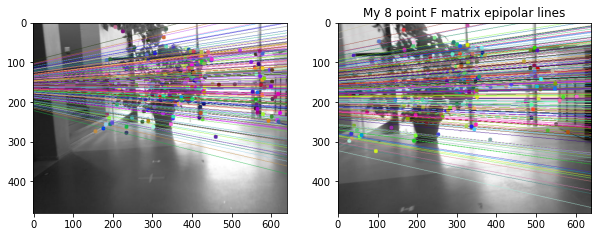

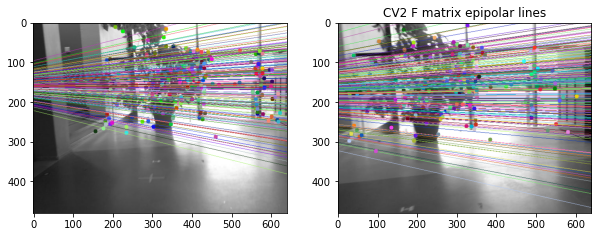

In [210]:
display_epipolar_lines(my_F, "My 8 point F matrix epipolar lines")
display_epipolar_lines(cv2_F, "CV2 F matrix epipolar lines")